In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm import tqdm
import datetime
import proplot as plot
from netCDF4 import Dataset
from wrf import getvar
import celer
from scipy.ndimage import gaussian_filter
import gc
%matplotlib inline

sys.path.insert(1, '/work/08350/tg876493/stampede2/python_codes/2020_TC_CRF/dev/freddy0218/tools/')
import derive_var
import read_and_proc
import mlr

plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

In [2]:
#Function####################################################
import json,pickle
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None

def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)

def flatten(t):
    #https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
    return [item for sublist in t for item in sublist]
def standardize(t,formula='I'):
    if formula=='I':
        return (t-np.min(np.asarray(t)))/(np.max(np.asarray(t))-np.min(np.asarray(t)))
    elif formula=='II':
        return (t-np.mean(np.asarray(t)))/(np.std(np.asarray(t)))
    
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import MultiTaskLassoCV
from celer import MultiTaskLassoCV
from celer import Lasso
from sklearn.linear_model import ElasticNet
def produce_regscore(inPUT=None,outPUT=None,aux_inPUT=None,outtype='score',do_aux=False,
                     algorithm='linear',lassoparam=dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha=0.001):
    if algorithm=='linear':
        reg = LinearRegression().fit(inPUT, outPUT)
    elif algorithm=='lasso':
        #reg = MultiTaskLassoCV(**lassoparam).fit(inPUT,outPUT)
        reg = Lasso(simplelassoalpha).fit(inPUT,outPUT)
    elif algorithm=='multilasso':
        reg = MultiTaskLassoCV(**lassoparam).fit(inPUT,outPUT)
    if outtype=='score':
        if do_aux is False:
            return reg.score(inPUT, outPUT)
        elif do_aux is True:
            return reg.score(aux_inPUT,outPUT)
    elif outtype=='predict':
        return reg.predict(inPUT)
    elif outtype=='coeff':
        return reg.coef_
    
def delete_padding(inTS=None,outTS=None):
    output_nozero,input_nozero = [],[]
    for i in range(len(outTS[:,0])):
        temp = outTS[i,:]
        tempin = inTS[i,:]
        if temp.all()==0:
            continue
        else:
            output_nozero.append(temp)
            input_nozero.append(tempin)
    return input_nozero,output_nozero

def output_regscore(inTS=None,outTS=None,LTlist=None,algorithm='linear',aux_inTS=None,do_aux=False,simplelassoalpha=0.001):
    if do_aux is False:
        return [produce_regscore(delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1],None,'score',False,algorithm,\
                                 dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]
    elif do_aux is True:
        return [produce_regscore(delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1],aux_inTS[:-int(LTlist[i])],'score',True,algorithm,\
                                 dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]
    
def output_regscore_withmemory(inTS=None,outTS=None,LTlist=None,algorithm='linear',aux_inTS=None,do_aux=False,simplelassoalpha=0.001):
    if do_aux is False:
        output = []
        for i in (range(len(outTS))):
            inTSn,outTSn = delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1]
            inTRAIN = np.concatenate(((inTSn[int(LTlist[i]):]),(inTSn[0:-int(LTlist[i])])),axis=1)
            outTRAIN = outTSn[int(LTlist[i]):]
            output.append(produce_regscore(inTRAIN,outTRAIN,None,'score',False,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha))
        return output
    elif do_aux is True:
        output = []
        for i in (range(len(outTS))):
            inTSn,outTSn = delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1]
            inTRAIN = np.concatenate(((inTSn[int(LTlist[i]):]),(inTSn[0:-int(LTlist[i])])),axis=1)
            outTRAIN = outTSn[int(LTlist[i])]
            auxin = np.concatenate(((aux_inTS[:-int(LTlist[i])][int(LTlist[i]):]),(aux_inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            output.append(produce_regscore(inTRAIN,outTRAIN,auxin,'score',True,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha))
        return output        
    
def output_regcoeff(inTS=None,outTS=None,LTlist=None,algorithm='linear',memory='with',simplelassoalpha=0.001):
    if memory=='with':
        output = []
        for i in range(len(outTS)):
            inarray = np.concatenate(((inTS[:-int(LTlist[i])][int(LTlist[i]):]),(inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            outarray = outTS[i][int(LTlist[i]):-int(LTlist[i])]
            output.append(produce_regscore(inarray,outarray,'coeff',algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01))
        return output
    elif memory=='without':
        return [produce_regscore(inTS[:-int(LTlist[i])],outTS[i][:-int(LTlist[i])],'coeff',algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]
    
def output_regpredict(inTS=None,outTS=None,LTlist=None,algorithm='linear',memory='without',simplelassoalpha=0.001):
    if memory=='with':
        output = []
        for i in range(len(outTS)):
            inarray = np.concatenate(((inTS[:-int(LTlist[i])][int(LTlist[i]):]),(inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            outarray = outTS[i][int(LTlist[i]):-int(LTlist[i])]
            output.append(produce_regscore(inarray,outarray,None,'predict',False,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01))
        return output
    elif memory=='without':
        return [produce_regscore(delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1],None,'predict',False,algorithm,
                                 dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]

In [3]:
#Function####################################################
import json,pickle
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None

def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
        
def do_PCA(var=None,timezoom=None,smooth='Yes',gaussian=0.9,fromcenter='Yes',inradius=None,outradius=None,donormal='Yes',do_PCA='Yes',do_center='No'):
    """
    Var: Input variable (must have 4 dimensions! Time-pres-theta-radius)
    """
    if smooth=='Yes':
        from scipy.ndimage import gaussian_filter
        normal_var = []
        if donormal=='Yes':
            for presindex in range(len(var[0,:,0,0])):
                normal_var.append(gaussian_filter(normalize_inner(var[:,presindex,:,:],outradius,'Yes'),sigma=gaussian))
        elif donormal=='No':
            if do_center=='Yes':
                for presindex in range(len(var[0,:,0,0])):
                    normal_var.append(gaussian_filter(normalize_inner(var[:,presindex,:,:],outradius,'No','Yes'),sigma=gaussian))
            elif do_center=='No':
                for presindex in range(len(var[0,:,0,0])):
                    normal_var.append(gaussian_filter(normalize_inner(var[:,presindex,:,:],outradius,'No','No'),sigma=gaussian))  
        normal_var = np.swapaxes(np.asarray(normal_var),0,1)
    else:
        normal_var = []
        for presindex in range(len(var[0,:,0,0])):
            normal_var.append(normalize_inner(var[:,presindex,:,:],outradius))
        normal_var = np.swapaxes(np.asarray(normal_var),0,1)
    if fromcenter=='Yes':
        normal_varf = np.asarray([normal_var[i,:,:,:outradius].flatten() \
                                  for i in range(len(normal_var[timezoom[0]:timezoom[1],0,0,0]))])
    elif fromcenter=='No':
        normal_varf = np.asarray([normal_var[i,:,:,inradius:outradius].flatten() \
                                  for i in range(len(normal_var[timezoom[0]:timezoom[1],0,0,0]))])        
    print("--Finish preprocesing--")
    if do_PCA=='Yes':
        from sklearn.decomposition import PCA
        import time
        start_time = time.time()
        skpcaVAR = PCA()
        skpcaVAR.fit(normal_varf.copy())
        print("--- %s seconds ---" % (time.time() - start_time))
        return skpcaVAR,normal_var,normal_varf
    else:
        return normal_var,normal_varf

def normalize_inner(var=None,outerradius=None,standard='Yes',docenter='No'):
    PWper_ctrl = []
    for indx in range(len(var[:,0,0])):
        if docenter=='Yes':
            temp = var[indx,:,:outerradius]-np.nanmean(var[indx,:,:outerradius],axis=(0,1))
        elif docenter=='No':
            temp = var[indx,:,:outerradius]
        if standard=='Yes':
            PWper_ctrl.append((temp-np.nanmean(temp))/np.nanstd(temp))
        elif standard=='No':
            PWper_ctrl.append((temp))
    del temp
    return np.asarray(PWper_ctrl)

def proc_invar_forPCA(var=None,timezoom=None,smooth='Yes',gaussian=[0,0,0],fromcenter='Yes',inradius=None,outradius=None,donormal='No',doPCA='No'):
    return do_PCA(var=var,timezoom=timezoom,smooth='Yes',gaussian=[0,0,0],fromcenter='Yes',inradius=None,outradius=None,donormal='No',doPCA='No')

def flatten(t):
    #https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
    return [item for sublist in t for item in sublist]
def standardize(t,formula='I'):
    if formula=='I':
        return (t-np.min(np.asarray(t)))/(np.max(np.asarray(t))-np.min(np.asarray(t)))
    elif formula=='II':
        return (t-np.mean(np.asarray(t)))/(np.std(np.asarray(t)))
    
def prepare_inputdataset(inputTS=None,flat_out=np.zeros((83,12+3+3+9)),lefttimelim=None):
    def flattenlist(inlist=None):
        tempvarlist = []
        for item in inlist:
            tempvarlist.append(item)
        return flatten(tempvarlist)
    input_dataset36 = []
    for timeseries in inputTS:#[pca_timeseries_36,pcaur_timeseries_36,pcavr_timeseries_36,pcaw_timeseries_36]:
        input_dataset36.append(timeseries)
    for i in (range(inputTS[0][:,0].shape[0])):
        tempinlist = [obj[i,:] for obj in input_dataset36]
        flat_out[i,:] = flattenlist(tempinlist)
    del timeseries,i
    return flat_out

def produce_testdataset(TYPE='orig',LT=1,expTYPE='R21'):
    if expTYPE=='R21':
        if TYPE=='TCr':
            output1_TCr = np.concatenate((prepare_inputdataset([forward_diff(pcaur_timeseries,60*60,0,LT),forward_diff(pcavr_timeseries,60*60,0,LT),forward_diff(pcaw_timeseries,60*60,0,LT)],np.zeros((96,4+3+9)),ctrl_t2),
                                          prepare_inputdataset([forward_diff(pcaur_timeseries_36[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcavr_timeseries_36[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_36[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,4+3+9)),ctrl_t2),
                                          prepare_inputdataset([forward_diff(pcaur_timeseries_60[60-ctrl_t2-5:],60*60,0,LT),forward_diff(pcavr_timeseries_60[60-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_60[60-ctrl_t2:],60*60,0,LT)],np.zeros((59,4+3+9)),ctrl_t2),
                                          prepare_inputdataset([forward_diff(pcaur_timeseries_lwcrf[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcavr_timeseries_lwcrf[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_lwcrf[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,4+3+9)),ctrl_t2)),axis=0)
            return output1_TCr
        elif TYPE=='orig':
            output1_orig = np.concatenate((prepare_inputdataset([forward_diff(pcau_timeseries,60*60,0,LT),forward_diff(pcav_timeseries,60*60,0,LT),forward_diff(pcaw_timeseries,60*60,0,LT)],np.zeros((96,3+3+9)),ctrl_t2),
                                           prepare_inputdataset([forward_diff(pcau_timeseries_36[36-ctrl_t2:],60*60,0,LT),forward_diff(pcav_timeseries_36[36-28:],60*60,0,LT),forward_diff(pcaw_timeseries_36[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,3+3+9)),ctrl_t2),
                                           prepare_inputdataset([forward_diff(pcau_timeseries_60[60-ctrl_t2:],60*60,0,LT),forward_diff(pcav_timeseries_60[60-28:],60*60,0,LT),forward_diff(pcaw_timeseries_60[60-ctrl_t2:],60*60,0,LT)],np.zeros((59,3+3+9)),ctrl_t2),
                                           prepare_inputdataset([forward_diff(pcau_timeseries_lwcrf[36-ctrl_t2:],60*60,0,LT),forward_diff(pcav_timeseries_lwcrf[36-28:],60*60,0,LT),forward_diff(pcaw_timeseries_lwcrf[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,3+3+9)),ctrl_t2)),axis=0)
            return output1_orig

def output_flatvar_PCAtransform(var=None,ctrlvar=None,needpatch=True,exp=None,timezoom=None,smooth=[3,0,0],inradius=None,outradius=None):
    if needpatch is True:
        patchvar = read_and_proc.add_ctrl_before_senstart(ctrlvar,var,exp,'Yes')
        del var
        _,outflatvarf = do_PCA(var=patchvar,timezoom=timezoom,smooth='Yes',
                               gaussian=smooth,fromcenter='Yes',inradius=inradius,outradius=outradius,donormal='No',do_PCA='No',do_center='No')
        return outflatvarf
    else:
        _,outflatvarf = do_PCA(var=var,timezoom=timezoom,smooth='Yes',
                               gaussian=smooth,fromcenter='Yes',inradius=inradius,outradius=outradius,donormal='No',do_PCA='No',do_center='No')
        return outflatvarf

def output_PCAtimeseries(PCAdict=None,varname=None,flatvar=None,no_comp=None,standard=True,standardtype='II'):
    if varname is None:
        varname=['dtheta','u','v','w','qv']
    timeseries_out = {}
    for index,var in enumerate(varname):
        if standard is True:
            timeseries_out[var] = standardize(PCA_dict[var].transform(flatvar[index])[:,0:no_comp[index]],standardtype)
        else:
            timeseries_out[var] = PCA_dict[var].transform(flatvar[index])[:,0:no_comp[index]]
    return timeseries_out

def produce_input(PCAtimeseries=None,expname='ncrf36',orig=True,leftstart=None,no_comp=None):
    if no_comp is None:
        no_comp=[12,3,3,9,5]
    if expname=='ctrl':
        if orig is True:
            totltime=96
            dtuvw = prepare_inputdataset([PCAtimeseries['u'],PCAtimeseries['v'],PCAtimeseries['w'],PCAtimeseries['dtheta']],
                                         np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[0])),leftstart)
            uv = prepare_inputdataset([PCAtimeseries['u'],PCAtimeseries['v']],np.zeros((totltime,no_comp[1]+no_comp[2])),leftstart)
            dtuv = prepare_inputdataset([PCAtimeseries['u'],PCAtimeseries['v'],PCAtimeseries['dtheta']],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[0])),leftstart)
            uvw = prepare_inputdataset([PCAtimeseries['u'],PCAtimeseries['v'],PCAtimeseries['w']],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3])),leftstart)
            uvwqv = prepare_inputdataset([PCAtimeseries['u'],PCAtimeseries['v'],PCAtimeseries['w'],PCAtimeseries['qv']],
                                     np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[4])),leftstart)
            uvqv = prepare_inputdataset([PCAtimeseries['u'],PCAtimeseries['v'],PCAtimeseries['qv']],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[4])),leftstart)
            dtuvwqv = prepare_inputdataset([PCAtimeseries['u'],PCAtimeseries['v'],PCAtimeseries['w'],PCAtimeseries['dtheta'],PCAtimeseries['qv']],
                                           np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[0]+no_comp[4])),leftstart)
            output_dict={'uv':uv,'uvw':uvw,'uvqv':uvqv,'uvwqv':uvwqv,'dtuvw':dtuvw,'dtuvwqv':dtuvwqv,'dtuv':dtuv}
            return output_dict
    else:
        if expname=='ncrf36':
            rsindx,totltime = 36,96-(36-23)
        elif expname=='ncrf60':
            rsindx,totltime = 60,96-(60-23)
        
        if orig is True:
            dtuvw = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart:],PCAtimeseries['v'][rsindx-leftstart:],
                                          PCAtimeseries['w'][rsindx-leftstart:],PCAtimeseries['dtheta'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[0])),leftstart)
            uv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart:],PCAtimeseries['v'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2])),leftstart)
            uvw = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart:],PCAtimeseries['v'][rsindx-leftstart:],PCAtimeseries['w'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3])),leftstart)
            dtuv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart:],PCAtimeseries['v'][rsindx-leftstart:],PCAtimeseries['dtheta'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[0])),leftstart)
            uvwqv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart:],PCAtimeseries['v'][rsindx-leftstart:],
                                          PCAtimeseries['w'][rsindx-leftstart:],PCAtimeseries['qv'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[4])),leftstart)
            uvqv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart:],PCAtimeseries['v'][rsindx-leftstart:],PCAtimeseries['qv'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[4])),leftstart)
            dtuvwqv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart:],PCAtimeseries['v'][rsindx-leftstart:],
                                            PCAtimeseries['w'][rsindx-leftstart:],PCAtimeseries['dtheta'][rsindx-leftstart:],
                                            PCAtimeseries['qv'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[0]+no_comp[4])),leftstart)
            output_dict={'uv':uv,'uvw':uvw,'uvqv':uvqv,'uvwqv':uvwqv,'dtuvw':dtuvw,'dtuvwqv':dtuvwqv,'dtuv':dtuv}
            return output_dict

def produce_output_LT(PCAtimeseries=None,expname=['ctrl','ncrf36','ncrf60','lwcrf'],orig=True,leadtime=None,nocomp=None):
    def output_timediff(LT=None,inputdict=None,settings=None,exp=None):
        if exp=='ctrl':
            a = prepare_inputdataset2([forward_diff(inputdict['u'],60*60,0,LT),forward_diff(inputdict['v'],60*60,0,LT),forward_diff(inputdict['w'],60*60,0,LT)],np.zeros((forward_diff(inputdict['u'],60*60,0,LT).shape[0],nocomp[1]+nocomp[2]+nocomp[3])),ctrl_t2)
            azero = np.zeros((LT,nocomp[1]+nocomp[2]+nocomp[3]))
            return np.concatenate((a,azero),axis=0)
        elif (exp=='ncrf36') or (exp=='lwcrf'):
            a = prepare_inputdataset2([forward_diff(inputdict['u'][36-ctrl_t2:],60*60,0,LT),forward_diff(inputdict['v'][36-ctrl_t2:],60*60,0,LT),forward_diff(inputdict['w'][36-ctrl_t2:],60*60,0,LT)],
                                        np.zeros((forward_diff(inputdict['u'][36-ctrl_t2:],60*60,0,LT).shape[0],nocomp[1]+nocomp[2]+nocomp[3])),ctrl_t2)
            azero = np.zeros((LT,nocomp[1]+nocomp[2]+nocomp[3]))
            return np.concatenate((a,azero),axis=0)
        elif exp=='ncrf60':
            a = prepare_inputdataset2([forward_diff(inputdict['u'][60-ctrl_t2:],60*60,0,LT),forward_diff(inputdict['v'][60-ctrl_t2:],60*60,0,LT),forward_diff(inputdict['w'][60-ctrl_t2:],60*60,0,LT)],
                                        np.zeros((forward_diff(inputdict['u'][60-ctrl_t2:],60*60,0,LT).shape[0],nocomp[1]+nocomp[2]+nocomp[3])),ctrl_t2)
            azero = np.zeros((LT,nocomp[1]+nocomp[2]+nocomp[3]))
            return np.concatenate((a,azero),axis=0)

    if orig is True:
        result = []
        for index,expNAME in enumerate(expname):
            result.append(output_timediff(LT=leadtime,inputdict=PCAtimeseries[index],settings=None,exp=expNAME))
        del index,expNAME
        result_con = np.concatenate((result),axis=0)
        return result_con
    
def prepare_inputdataset2(inputTS=None,flat_out=np.zeros((83,12+3+3+9)),lefttimelim=None):
    def flattenlist(inlist=None):
        tempvarlist = []
        for item in inlist:
            tempvarlist.append(item)
        return flatten(tempvarlist)
    input_dataset36 = []
    for timeseries in inputTS:#[pca_timeseries_36,pcaur_timeseries_36,pcavr_timeseries_36,pcaw_timeseries_36]:
        input_dataset36.append(timeseries)
    for i in (range(inputTS[0][:,0].shape[0])):
        tempinlist = [obj[i,:] for obj in input_dataset36]
        flat_out[i,:] = flattenlist(tempinlist)
    del timeseries,i
    return flat_out

def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None
#    produce_testdataset(TYPE='TCr',LT=1,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=2,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=3,expTYPE='R21')

In [4]:
############################################################################################################################################
# PCA_dict: Processed EOF objects; A_dict: Variable anomaly matrices; Af_dict: Flattened variable anomaly matrices
# *note that following EOF conventions, we derived EOFs with anomalies.
############################################################################################################################################
import pickle
path = './output/1010_nc/'
buoy='No'
if buoy=='Yes':
    filePCA = [path+'BUOY_pca_nc',path+'U_pca_nc',path+'V_pca_nc',path+'W_pca_nc',path+'QV_pca_nc']
    fileAf = [path+'normalBUOY_ctrlf_nc',path+'normalUrad_ctrlf_nc',path+'normalVtan_ctrlf_nc',path+'normalW_ctrlf_nc',path+'normalQV_ctrlf_nc']
else:
    filePCA = [path+'T_pca_nc',path+'U_pca_nc',path+'V_pca_nc',path+'W_pca_nc',path+'QV_pca_nc']
    fileAf = [path+'normalT_ctrlf_nc',path+'normalUrad_ctrlf_nc',path+'normalVtan_ctrlf_nc',path+'normalW_ctrlf_nc',path+'normalQV_ctrlf_nc']
    
outputPCA,outputA,outputAf = [],[],[]
for i in range(len(filePCA)):
    with open(filePCA[i],'rb') as f:
        outputPCA.append(pickle.load(f))
del i
for i in range(len(fileAf)):
    with open(fileAf[i],'rb') as f:
        outputAf.append(pickle.load(f))

PCA_dict = {'dtheta':outputPCA[0],'u':outputPCA[1],'v':outputPCA[2],'w':outputPCA[3],'qv':outputPCA[4]}#,'ugrad':outputPCA[5],'vgrad':outputPCA[6],'wgrad':outputPCA[6]}
Af_dict = {'dtheta':outputAf[0],'u':outputAf[1],'v':outputAf[2],'w':outputAf[3],'qv':outputAf[4]}#,'ugrad':outputAf[5],'vgrad':outputAf[6],'wgrad':outputAf[6]}

fileA = [path+'normalBUOY_ctrl_nc']
outputA = []
for i in range(len(fileA)):
    with open(fileA[i],'rb') as f:
        outputA.append(pickle.load(f))
A_dict = {'dtheta':outputA[0]}
del outputPCA,outputAf,outputA
gc.collect()

84

### Process WRF radiative heating and residual heating 

In [5]:
import gc
origin_path = '/scratch/06040/tg853394/tc/output/redux/maria/'
from scipy.ndimage import gaussian_filter
#############################################################
ctrlvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_RTHRATLW_0-144hr.nc',origin_path+'ctl/azim_RTHRATSW_0-144hr.nc'],fieldname=['RTHRATLW','RTHRATSW'])
ncrf60var_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ncrf_60h/azim_RTHRATLW_60-144hr.nc',origin_path+'ncrf_60h/azim_RTHRATSW_60-144hr.nc'],fieldname=['RTHRATLW','RTHRATSW'])
ncrf36var_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ncrf_36h/azim_RTHRATLW_36-144hr.nc',origin_path+'ncrf_36h/azim_RTHRATSW_36-144hr.nc'],fieldname=['RTHRATLW','RTHRATSW'])
lwcrfvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'lwcrf/azim_RTHRATLW_36-144hr.nc',origin_path+'lwcrf/azim_RTHRATSW_36-144hr.nc'],fieldname=['RTHRATLW','RTHRATSW'])

path = '/work2/08350/tg876493/stampede2/python_codes/tcg_radiation/output/'
file = [path+'ctrl_thetaall',path+'ncrf36_thetaall',path+'ncrf60_thetaall',path+'lwcrf_thetaall']
output = []
for i in range(len(file)):
    with open(file[i],'rb') as f:
        output.append(pickle.load(f))
theta_dict = {'CTRL_theta':output[0],'NCRF36_theta':output[1],'NCRF60_theta':output[2],'LWCRF_theta':output[3]}
# To be consistent with azimuthal files
########################################################################################################
ctrl_thetaA,ncrf36_thetaA,ncrf60_thetaA,lwcrf_thetaA = np.swapaxes(np.asarray(theta_dict['CTRL_theta']),0,1),\
np.swapaxes(np.asarray(theta_dict['NCRF36_theta']),0,1),np.swapaxes(np.asarray(theta_dict['NCRF60_theta']),0,1),np.swapaxes(np.asarray(theta_dict['LWCRF_theta']),0,1)
del output,theta_dict#,outputPCA,outputAf
gc.collect()

###################################################################
# Cut off time
###################################################################
ctrl_t2,ctrl_t4 = nearest_index(ctrlvar_dict['RTHRATLW']['RTHRATLW'].time/24,1)-1,nearest_index(ctrlvar_dict['RTHRATLW']['RTHRATLW'].time/24,5)-1
###################################################################
# Heating Rate
###################################################################
ncrf36_thetaA_n,ncrf60_thetaA_n,lwcrf_thetaA_n = read_and_proc.add_ctrl_before_senstart(ctrl_thetaA,ncrf36_thetaA,'NCRF36','Yes'),\
read_and_proc.add_ctrl_before_senstart(ctrl_thetaA,ncrf60_thetaA,'NCRF60','Yes'),read_and_proc.add_ctrl_before_senstart(ctrl_thetaA,lwcrf_thetaA,'NCRF36','Yes')

ctrl_thetagrad_b,ncrf36_thetagrad_b,ncrf60_thetagrad_b,lwcrf_thetagrad_b = forward_diff(gaussian_filter(ctrl_thetaA,sigma=[3,0,0,0]),60*60,0),forward_diff(gaussian_filter(ncrf36_thetaA_n,sigma=[3,0,0,0]),60*60,0),\
forward_diff(gaussian_filter(ncrf60_thetaA_n,sigma=[3,0,0,0]),60*60,0),forward_diff(gaussian_filter(lwcrf_thetaA_n,sigma=[3,0,0,0]),60*60,0)

def proc_invar_forPCA(var=None,timezoom=[ctrl_t2,ctrl_t4],smooth='Yes',gaussian=[0,0,0],fromcenter='Yes',inradius=None,outradius=None,donormal='No',doPCA='No'):
    return do_PCA(var=var,timezoom=[ctrl_t2,ctrl_t4],smooth='Yes',gaussian=[0,0,0],fromcenter='Yes',inradius=None,outradius=None,donormal='No',doPCA='No')

#### Radiative Heating + Residual Heating

In [6]:
del ctrl_thetaA,ncrf36_thetaA,ncrf60_thetaA
gc.collect()

rad_ctrl = gaussian_filter(ctrlvar_dict['RTHRATLW']['RTHRATLW']+ctrlvar_dict['RTHRATSW']['RTHRATSW'],[3,0,0,0])
rad_ncrf36 = read_and_proc.add_ctrl_before_senstart(rad_ctrl,gaussian_filter(ncrf36var_dict['RTHRATLW']['RTHRATLW']+ncrf36var_dict['RTHRATSW']['RTHRATSW'],[3,0,0,0]),'NCRF36','Yes')
rad_ncrf60 = read_and_proc.add_ctrl_before_senstart(rad_ctrl,gaussian_filter(ncrf60var_dict['RTHRATLW']['RTHRATLW']+ncrf60var_dict['RTHRATSW']['RTHRATSW'],[3,0,0,0]),'NCRF60','Yes')
rad_lwcrf = read_and_proc.add_ctrl_before_senstart(rad_ctrl,gaussian_filter(lwcrfvar_dict['RTHRATLW']['RTHRATLW']+lwcrfvar_dict['RTHRATSW']['RTHRATSW'],[3,0,0,0]),'NCRF36','Yes')

resid_ctrl = ctrl_thetagrad_b-rad_ctrl[1:]
resid_ncrf36 = ncrf36_thetagrad_b-rad_ncrf36[1:]
resid_ncrf60 = ncrf60_thetagrad_b-rad_ncrf60[1:]
resid_lwcrf = lwcrf_thetagrad_b-rad_lwcrf[1:]
del ncrf36var_dict,ncrf60var_dict,lwcrfvar_dict
gc.collect()

60

In [7]:
# Heating Rate
#########################################################################################################
r0,r200=(nearest_index(ctrlvar_dict['RTHRATLW']['RTHRATLW'].radius,0),nearest_index(ctrlvar_dict['RTHRATLW']['RTHRATLW'].radius,200))
r300,r500=(nearest_index(ctrlvar_dict['RTHRATLW']['RTHRATLW'].radius,300),nearest_index(ctrlvar_dict['RTHRATLW']['RTHRATLW'].radius,500))
########################################################################################################################
# Patch data
########################################################################################################################
normalradctrlf = output_flatvar_PCAtransform(rad_ctrl,None,False,'NCRF36',[ctrl_t2,ctrl_t4],[0,0,0],None,r500)
normalradncrf36f,normalradncrf60f,normalradlwcrff = output_flatvar_PCAtransform(rad_ncrf36,None,False,'NCRF36',[ctrl_t2,ctrl_t4],[0,0,0],None,r500),\
output_flatvar_PCAtransform(rad_ncrf60,None,False,'NCRF60',[ctrl_t2,ctrl_t4],[0,0,0],None,r500),\
output_flatvar_PCAtransform(rad_lwcrf,None,False,'NCRF36',[ctrl_t2,ctrl_t4],[0,0,0],None,r500)

normalresidctrlf = output_flatvar_PCAtransform(resid_ctrl,None,False,'NCRF36',[ctrl_t2,ctrl_t4],[0,0,0],None,r500)
normalresidncrf36f,normalresidncrf60f,normalresidlwcrff = output_flatvar_PCAtransform(resid_ncrf36,None,False,'NCRF36',[ctrl_t2,ctrl_t4],[0,0,0],None,r500),\
output_flatvar_PCAtransform(resid_ncrf60,None,False,'NCRF60',[ctrl_t2,ctrl_t4],[0,0,0],None,r500),\
output_flatvar_PCAtransform(resid_lwcrf,None,False,'NCRF36',[ctrl_t2,ctrl_t4],[0,0,0],None,r500)

del rad_ctrl,rad_ncrf36,rad_ncrf60,rad_lwcrf,resid_ctrl,resid_ncrf36,resid_ncrf60,resid_lwcrf
gc.collect()

--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--


0

#### Save to pickle

In [8]:
save_to_pickle('./output/1010_nc/radiation/normalRAD_ctrlf_nc',normalradctrlf)
save_to_pickle('./output/1010_nc/radiation/normalRAD_ncrf36f_nc',normalradncrf36f)
save_to_pickle('./output/1010_nc/radiation/normalRAD_ncrf60f_nc',normalradncrf60f)
save_to_pickle('./output/1010_nc/radiation/normalRAD_lwcrff_nc',normalradlwcrff)

save_to_pickle('./output/1010_nc/radiation/normalRESI_ctrlf_nc',normalresidctrlf)
save_to_pickle('./output/1010_nc/radiation/normalRESI_ncrf36f_nc',normalresidncrf36f)
save_to_pickle('./output/1010_nc/radiation/normalRESI_ncrf60f_nc',normalresidncrf60f)
save_to_pickle('./output/1010_nc/radiation/normalRESI_lwcrff_nc',normalresidlwcrff)

### Read in processed heating data

In [5]:
path = './output/1010_nc/radiation/'
fileAf = [path+'normalRAD_ctrlf_nc',path+'normalRAD_ncrf36f_nc',path+'normalRAD_ncrf60f_nc',path+'normalRAD_lwcrff_nc',path+'normalRESI_ctrlf_nc',path+'normalRESI_ncrf36f_nc',path+'normalRESI_ncrf60f_nc',path+'normalRESI_lwcrff_nc']
outputAf = []
for i in range(len(fileAf)):
    with open(fileAf[i],'rb') as f:
        outputAf.append(pickle.load(f))

RAD_dict = {'ctrl':outputAf[0],'ncrf36':outputAf[1],'ncrf60':outputAf[2],'lwcrf':outputAf[3]}#,'ugrad':outputPCA[5],'vgrad':outputPCA[6],'wgrad':outputPCA[6]}
RESI_dict = {'ctrl':outputAf[4],'ncrf36':outputAf[5],'ncrf60':outputAf[6],'lwcrf':outputAf[7]}#,'ugrad':outputAf[5],'vgrad':outputAf[6],'wgrad':outputAf[6]}
del outputAf
gc.collect()

18

In [6]:
allheat_timeseries = PCA_dict['dtheta'].transform(Af_dict['dtheta'])[:,0:12]
rad_timeseries = PCA_dict['dtheta'].transform(RAD_dict['ctrl'])[:,0:12]
resi_timeseries = PCA_dict['dtheta'].transform(RESI_dict['ctrl'])[:,0:12]

In [32]:
index = np.linspace(0,11,12)#[2,4,6]
index2 = [2,4,6]
#rad = [((rad_timeseries[:,int(i)]-np.nanmean(rad_timeseries[:,int(i)])))/np.nanstd(rad_timeseries[:,int(i)]) for i in index2]
#resi = [((resi_timeseries[:,int(i)]-np.nanmean(resi_timeseries[:,int(i)])))/np.nanstd(resi_timeseries[:,int(i)]) for i in index2]
#allheat = [((allheat_timeseries[:,int(i)]-np.nanmean(allheat_timeseries[:,int(i)])))/np.nanstd(allheat_timeseries[:,int(i)]) for i in index2]
rad = [rad_timeseries[:,int(i)] for i in index2]
resi = [resi_timeseries[:,int(i)] for i in index2]
allheat = [allheat_timeseries[:,int(i)] for i in index2]

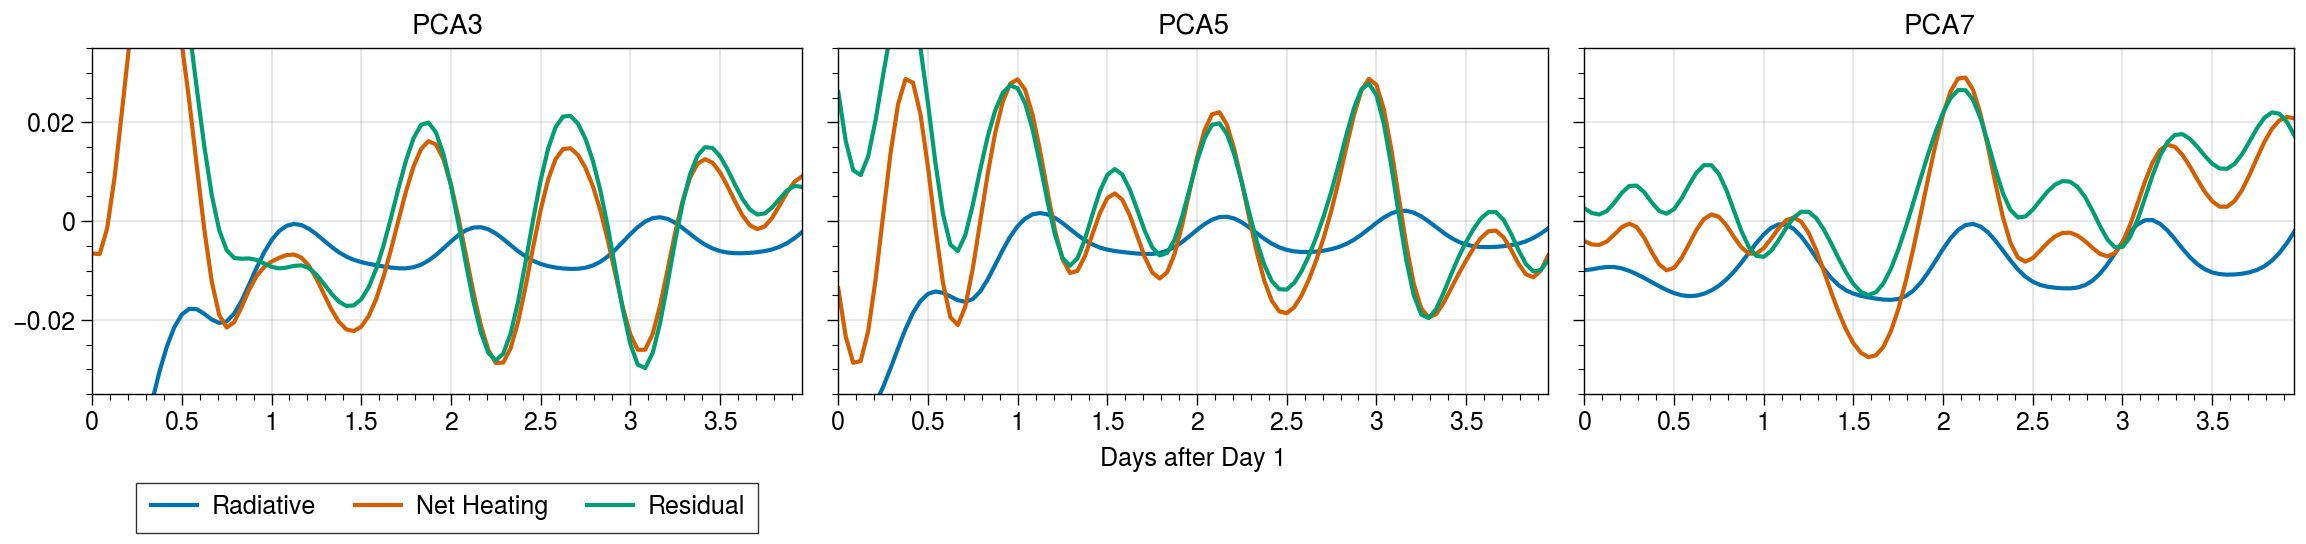

In [33]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.55,refaspect=2.051)
axs[0].plot(np.linspace(0,95,96)/24,(rad)[0],label='Radiative')
axs[0].plot(np.linspace(0,95,96)/24,(allheat)[0],label='Net Heating')
axs[0].plot(np.linspace(0,95,96)/24,(resi)[0],label='Residual')
axs[0].legend(loc='b')
axs[0].format(xlabel='Days after Day 1',title='PCA'+(str(index2[0]+1)),ylim=[-0.035,0.035])

axs[1].plot(np.linspace(0,95,96)/24,(rad)[1],label='Radiative')
axs[1].plot(np.linspace(0,95,96)/24,(allheat)[1],label='Net Heating')
axs[1].plot(np.linspace(0,95,96)/24,(resi)[1],label='Residual')
axs[1].format(xlabel='Days after Day 1',title='PCA'+(str(index2[1]+1)),ylim=[-0.035,0.035])

axs[2].plot(np.linspace(0,95,96)/24,(rad)[2],label='Radiative')
axs[2].plot(np.linspace(0,95,96)/24,(allheat)[2],label='Net Heating')
axs[2].plot(np.linspace(0,95,96)/24,(resi)[2],label='Residual')
axs[2].format(xlabel='Days after Day 1',title='PCA'+(str(index2[2]+1)),ylim=[-0.035,0.035])
plt.savefig('./proc_fig/1212/12hr_important_PCs.png',dpi=400)
plt.show()

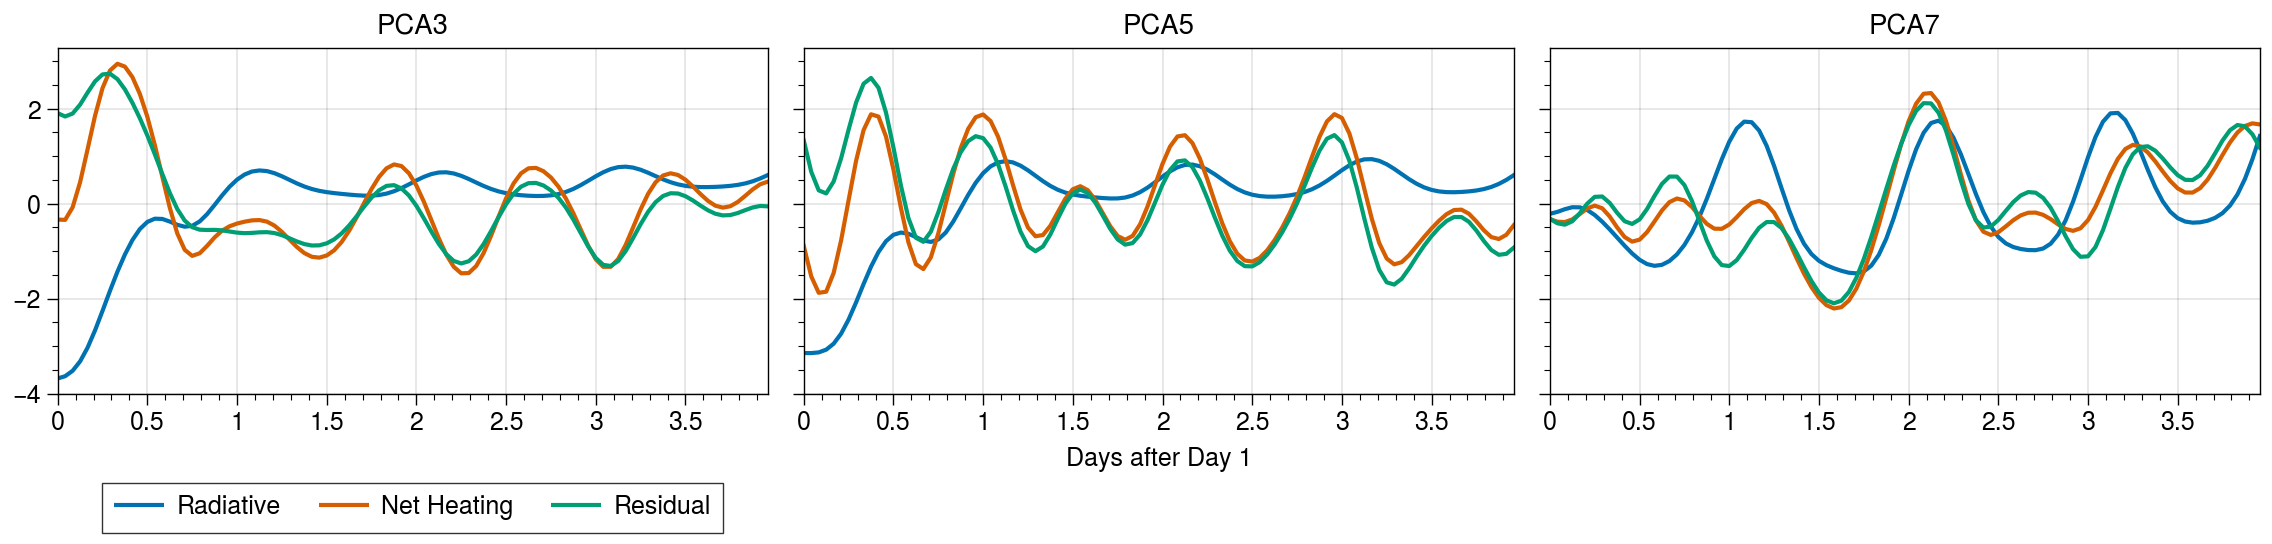

In [31]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.55,refaspect=2.051)
axs[0].plot(np.linspace(0,95,96)/24,(rad)[0],label='Radiative')
axs[0].plot(np.linspace(0,95,96)/24,(allheat)[0],label='Net Heating')
axs[0].plot(np.linspace(0,95,96)/24,(resi)[0],label='Residual')
axs[0].legend(loc='b')
axs[0].format(xlabel='Days after Day 1',title='PCA'+(str(index2[0]+1)),)#ylim=[-0.025,0.025])

axs[1].plot(np.linspace(0,95,96)/24,(rad)[1],label='Radiative')
axs[1].plot(np.linspace(0,95,96)/24,(allheat)[1],label='Net Heating')
axs[1].plot(np.linspace(0,95,96)/24,(resi)[1],label='Residual')
axs[1].format(xlabel='Days after Day 1',title='PCA'+(str(index2[1]+1)),)#ylim=[-0.025,0.025])

axs[2].plot(np.linspace(0,95,96)/24,(rad)[2],label='Radiative')
axs[2].plot(np.linspace(0,95,96)/24,(allheat)[2],label='Net Heating')
axs[2].plot(np.linspace(0,95,96)/24,(resi)[2],label='Residual')
axs[2].format(xlabel='Days after Day 1',title='PCA'+(str(index2[2]+1)),)#ylim=[-0.025,0.025])
plt.savefig('./proc_fig/1212/12hr_important_PCs_normalized.png',dpi=400)
plt.show()

In [63]:
[np.nanmean((rad[i]))/np.nanmean((allheat[i])) for i in range(11)],[np.nanmean((resi[i]))/np.nanmean((allheat[i])) for i in range(11)]

([-23.51515,
  14.400001,
  3.1428573,
  4.2352943,
  -2.0,
  -2.0645163,
  19.0,
  1.3333334,
  0.0,
  16.0,
  -4.0],
 [0.54545456,
  0.20000002,
  1.3571429,
  -0.94117653,
  0.8,
  -0.70967746,
  -9.0,
  -3.111111,
  0.0,
  19.999998,
  2.0])

### PCA databank

In [65]:
def export_corrmap(PCAinput=None,orig_normalarray=None,orig_flatarray=None,component=4,TYPE='correlation'):
    # Adapted from eofs package
    slicer = slice(0,component)
    dt_eigenvector = PCAinput.components_[:,slicer].copy()/np.sqrt(PCAinput.explained_variance_[slicer])
    dt_eigenvector_a = dt_eigenvector-np.nanmean(dt_eigenvector,axis=0)
    ############################################
    # Center pcs and field
    ############################################
    pcs_std = np.nanstd(dt_eigenvector_a,axis=0)
    field_std = np.nanstd(orig_flatarray,axis=0)
    ############################################
    # Set the divisor.
    ############################################
    div = np.float64(dt_eigenvector_a.shape[0])
    ############################################
    # Compute the correlation map.
    ############################################
    cor = np.ma.dot(orig_flatarray.T, dt_eigenvector_a).T / div
    if TYPE=='correlation':
        cor = np.ma.masked_invalid(cor)
        cor /= np.ma.outer(pcs_std, field_std)
    else:
        cor=cor
    
    output = []
    for cornum in cor:
        output.append(cornum.reshape(orig_normalarray[0,:,:,:].shape))
    return output

import scipy
def azimuth2angle(azimuth=None):
    """
    https://math.stackexchange.com/questions/926226/conversion-from-azimuth-to-counterclockwise-angle
    """
    angletest = 450-azimuth
    for index,item in enumerate(angletest):
        if item>360:
            angletest[index] = item-360
        else:
            continue
    return angletest

def closest_index(array=None,target=None):
    return np.abs(array-target).argmin()

def polar2cartesian(outcoords, inputshape, origin):
    """Coordinate transform for converting a polar array to Cartesian coordinates. 
    inputshape is a tuple containing the shape of the polar array. origin is a
    tuple containing the x and y indices of where the origin should be in the
    output array."""

    xindex, yindex = outcoords
    x0, y0 = origin
    x = xindex - x0
    y = yindex - y0

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    theta_index = np.round((theta + np.pi) * inputshape[1] / (2 * np.pi))

    return (r,theta_index)

def proc_tocart(polarfield=None,angle=None,twoD=True,twoDlv=None,standard=False):
    if twoD==True:
        PWnew = [np.asarray(polarfield)[int(twoDlv),int(np.abs(ANGLE-360).argmin()),:]]
        for i in np.linspace(0,358,359):
            PWnew.append(np.asarray(polarfield)[int(twoDlv),int(np.abs(ANGLE-i).argmin()),:])
        PWnew = np.swapaxes(np.asarray(PWnew),0,1)
        del i
        
        if standard==True:
            PWnew = (PWnew-np.nanmean(PWnew))/np.nanstd(PWnew)
        else:
            PWnew=PWnew

        test_2cartesian = scipy.ndimage.geometric_transform(PWnew, 
                                                            polar2cartesian,order=0,mode='constant',
                                                            output_shape = \
                                                            (PWnew.shape[0] * 2,PWnew.shape[0] * 2),
                                                            extra_keywords = \
                                                            {'inputshape':PWnew.shape,
                                                             'origin':(PWnew.shape[0],PWnew.shape[0])})
        #print('Finish processing')
        return ((test_2cartesian))

In [5]:
origin_path = '/scratch/06040/tg853394/tc/output/redux/maria/'
#############################################################
import json,pickle
def read_some_azimuth_fields(fileloc=None,fieldname=None):
    dict_name = {}
    for inx,obj in enumerate(fileloc):
        field_read = xr.open_dataset(obj)
        dict_name[fieldname[inx]] = field_read
    return dict_name
#########################################################################################################
ctrlvar_dict = read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_U10_0-144hr.nc'],fieldname=['U10'])
r0,r200=(nearest_index(ctrlvar_dict['U10']['U10'].radius,0),nearest_index(ctrlvar_dict['U10']['U10'].radius,200))
r300,r500=(nearest_index(ctrlvar_dict['U10']['U10'].radius,300),nearest_index(ctrlvar_dict['U10']['U10'].radius,500))

In [8]:
def export_corrmap(PCAinput=None,orig_normalarray=None,orig_flatarray=None,component=4,TYPE='correlation'):
    # Adapted from eofs package
    slicer = slice(0,component)
    dt_eigenvector = PCAinput.components_[:,slicer].copy()/np.sqrt(PCAinput.explained_variance_[slicer])
    dt_eigenvector_a = dt_eigenvector-np.nanmean(dt_eigenvector,axis=0)
    ############################################
    # Center pcs and field
    ############################################
    pcs_std = np.nanstd(dt_eigenvector_a,axis=0)
    field_std = np.nanstd(orig_flatarray,axis=0)
    ############################################
    # Set the divisor.
    ############################################
    div = np.float64(dt_eigenvector_a.shape[0])
    ############################################
    # Compute the correlation map.
    ############################################
    cor = np.ma.dot(orig_flatarray.T, dt_eigenvector_a).T / div
    if TYPE=='correlation':
        cor = np.ma.masked_invalid(cor)
        cor /= np.ma.outer(pcs_std, field_std)
    else:
        cor=cor
    
    output = []
    for cornum in cor:
        output.append(cornum.reshape(orig_normalarray[0,:,:,:].shape))
    return output

import scipy
def azimuth2angle(azimuth=None):
    """
    https://math.stackexchange.com/questions/926226/conversion-from-azimuth-to-counterclockwise-angle
    """
    angletest = 450-azimuth
    for index,item in enumerate(angletest):
        if item>360:
            angletest[index] = item-360
        else:
            continue
    return angletest

def closest_index(array=None,target=None):
    return np.abs(array-target).argmin()

def polar2cartesian(outcoords, inputshape, origin):
    """Coordinate transform for converting a polar array to Cartesian coordinates. 
    inputshape is a tuple containing the shape of the polar array. origin is a
    tuple containing the x and y indices of where the origin should be in the
    output array."""

    xindex, yindex = outcoords
    x0, y0 = origin
    x = xindex - x0
    y = yindex - y0

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    theta_index = np.round((theta + np.pi) * inputshape[1] / (2 * np.pi))

    return (r,theta_index)

def proc_tocart(polarfield=None,angle=None,twoD=True,twoDlv=None,standard=False):
    if twoD==True:
        PWnew = [np.asarray(polarfield)[int(twoDlv),int(np.abs(ANGLE-360).argmin()),:]]
        for i in np.linspace(0,358,359):
            PWnew.append(np.asarray(polarfield)[int(twoDlv),int(np.abs(ANGLE-i).argmin()),:])
        PWnew = np.swapaxes(np.asarray(PWnew),0,1)
        del i
        
        if standard==True:
            PWnew = (PWnew-np.nanmean(PWnew))/np.nanstd(PWnew)
        else:
            PWnew=PWnew

        test_2cartesian = scipy.ndimage.geometric_transform(PWnew, 
                                                            polar2cartesian,order=0,mode='constant',
                                                            output_shape = \
                                                            (PWnew.shape[0] * 2,PWnew.shape[0] * 2),
                                                            extra_keywords = \
                                                            {'inputshape':PWnew.shape,
                                                             'origin':(PWnew.shape[0],PWnew.shape[0])})
        #print('Finish processing')
        return ((test_2cartesian))
    
def display_crosssection(corrmap=None,xaxis=ctrlvar_dict['U10'].radius[:r500],
                         yaxis=None,index=None,standard=True,ax=None,rtitle=None,clv=np.linspace(-5,5,41),cticks=None,ALL=False,customtitle=None):
    if standard is True:
        toplot = np.nanmean((np.asarray(corrmap)-np.nanmean(np.asarray(corrmap)))/np.nanstd(np.asarray(corrmap)),axis=1)
    else:
        toplot = np.asarray(corrmap)
    img=ax.contourf(xaxis,yaxis,toplot,levels=clv,cmap='balance',extend='both')
    ax.colorbar(img,loc='ur',ticks=cticks)
    if ALL is False:
        ax.format(ltitle=r'PCA0'+str(index+1),rtitle=rtitle,xlabel='Distance from TC centre (km)',ylabel='Pressure (hPa)',ylim=[1000,50])
    elif ALL is True:
        ax.format(ltitle=customtitle,rtitle=rtitle,xlabel='Distance from TC centre (km)',ylabel='Pressure (hPa)',ylim=[1000,50])
    ax.yaxis.label.set_size(8.5)
    ax.xaxis.label.set_size(8.5)
    ax.tick_params(axis='both', which='major', labelsize=8)
    return ax
        #plt.gca().invert_yaxis()
        
def display_avgprofil(corrmap=None,yaxis=None,index=None,standard=True,radius=None,ax=None,xlabel=None,color=['k','r'],lw=2,alpha=0.6,ALL=False,customtitle=None):
    if standard is True:
        arrayS = (np.asarray(corrmap)-np.nanmean(np.asarray(corrmap)))/np.nanstd(np.asarray(corrmap))
    else:
        arrayS = np.asarray(corrmap)
    profilIN = np.nanmean(arrayS[:,:,radius[0]:radius[1]],axis=(1,2))
    profilOUT = np.nanmean(arrayS[:,:,radius[1]:radius[2]],axis=(1,2))
    profilavg = np.nanmean(arrayS[:,:,radius[0]:radius[2]],axis=(1,2))
    flattened = np.concatenate((profilIN,profilOUT)).flatten()
    ax.plot(profilIN,yaxis,c=color[0],lw=lw,alpha=alpha,label='0-200 km')
        #ax.plot(profilOUT,yaxis,c=color[1],lw=lw,alpha=alpha,label='200-500 km')
    if ALL is False:
        ax.format(title=r'PCA0'+str(index+1),xlabel=xlabel,ylabel='Pressure (hPa)',ylim=[1000,50],xlim=[np.min(flattened)*1.1,np.max(flattened)*1.1])
    else:
        ax.format(title=customtitle,xlabel=xlabel,ylabel='Pressure (hPa)',ylim=[1000,50],xlim=[np.min(flattened)*1.1,np.max(flattened)*1.1])
    ax.yaxis.label.set_size(8.5)
    ax.xaxis.label.set_size(8.5)
    ax.legend(loc='r',ncols=1)
    ax.tick_params(axis='both', which='major', labelsize=8) 
    return ax

def display_cart(corrmap=None,axs=None,index=None,heightindex=[6,20,32],cart_axis=None,ANGLE=None):
    #levels_u,levels_du,levels_dt=np.linspace(-3,3,31),np.linspace(-0.1,0.1,41),np.linspace(-0.08,0.08,33)
    for count,heightindx in enumerate((heightindex)):
        #maptoplot_tostand = corrmap[index][heightindx]
        toplot = np.fliplr(np.flipud((proc_tocart(corrmap,ANGLE,True,heightindx,False))))
        img = axs[count].contourf(cart_axis,cart_axis,toplot,levels=np.linspace(-np.max(np.abs(toplot))*1.05,np.max(np.abs(toplot))*1.05,21),cmap='balance',extend='both') #-.08,.08,33 (dt) -.1,.1,41 (du/dv)
        axs[count].colorbar(img,loc='b',ticks=[np.round(-np.max(np.abs(toplot))/1.5),0,np.round(np.max(np.abs(toplot))/1.5)])
        axs[count].format(xlabel='X (km)',ylabel='Y (km)',title=r'{} hPa'.format(int(coor.pres[heightindx].data)))
        axs[count].yaxis.label.set_size(8.5)
        axs[count].xaxis.label.set_size(8.5)
        axs[count].tick_params(axis='both', which='major', labelsize=8)
    return axs

In [7]:
path = './output/1010_nc/'
buoy='No'
if buoy=='Yes':
    fileA = [path+'normalBUOY_ctrl_nc',path+'normalUrad_ctrl_nc',path+'normalVtan_ctrl_nc',path+'normalW_ctrl_nc',path+'normalQV_ctrl_nc']
else:
    fileA = [path+'normalT_ctrl_nc',path+'normalUrad_ctrl_nc',path+'normalVtan_ctrl_nc',path+'normalW_ctrl_nc',path+'normalQV_ctrl_nc']

outputPCA,outputA,outputAf = [],[],[]
for i in range(len(filePCA)):
    with open(fileA[i],'rb') as f:
        outputA.append(pickle.load(f))
A_dict = {'dtheta':outputA[0],'u':outputA[1],'v':outputA[2],'w':outputA[3],'qv':outputA[4]}

In [10]:
dt_corrmap = export_corrmap(PCA_dict['dtheta'],A_dict['dtheta'],Af_dict['dtheta'],12,'covariance')
#rad_corrmap = export_corrmap(PCA_dict['dtheta'],A_dict['dtheta'],RAD_dict['ctrl'],12,'covariance')
#resi_corrmap = export_corrmap(PCA_dict['dtheta'],A_dict['dtheta'],RESI_dict['ctrl'],12,'covariance')

In [15]:
############################################################################################################################################
ANGLE = azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-ctrlvar_dict['U10'].radius[:r500]),ctrlvar_dict['U10'].radius[:r500][:]))
path_coor = '/scratch/06040/tg853394/tc/output/redux/maria/ctl/post/U.nc'
coor = xr.open_dataset(path_coor)
############################################################################################################################################
array = [[1, 1, 2],[3, 4, 5]]
for i in tqdm(range(12)):
    plotcomp=i
    plotarray = dt_corrmap
    plotlabel = r'd$d\theta/$dt$_{S}$'
    fig,axs = plot.subplots(array,axwidth=3.85,refaspect=2.051,span=False,sharex=False)
    display_crosssection(plotarray[plotcomp],ctrlvar_dict['U10'].radius[:r500],coor.pres,plotcomp,
                         True,axs[0],plotlabel,np.linspace(-5,5,41),[-4,0,4])
    display_avgprofil(plotarray[plotcomp],coor.pres,plotcomp,True,[0,r200,r500],axs[1],plotlabel,['k','r'],2,0.6)
    display_cart(plotarray[plotcomp],[axs[2],axs[3],axs[4]],plotcomp,[6,20,32],NEWCART_axis,ANGLE)
    plt.savefig('./proc_fig/1212/pca_dtheta/structure_dthdt_PCA0'+str(plotcomp+1)+'.png',dpi=200)
    plt.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [11:04<00:00, 55.42s/it]


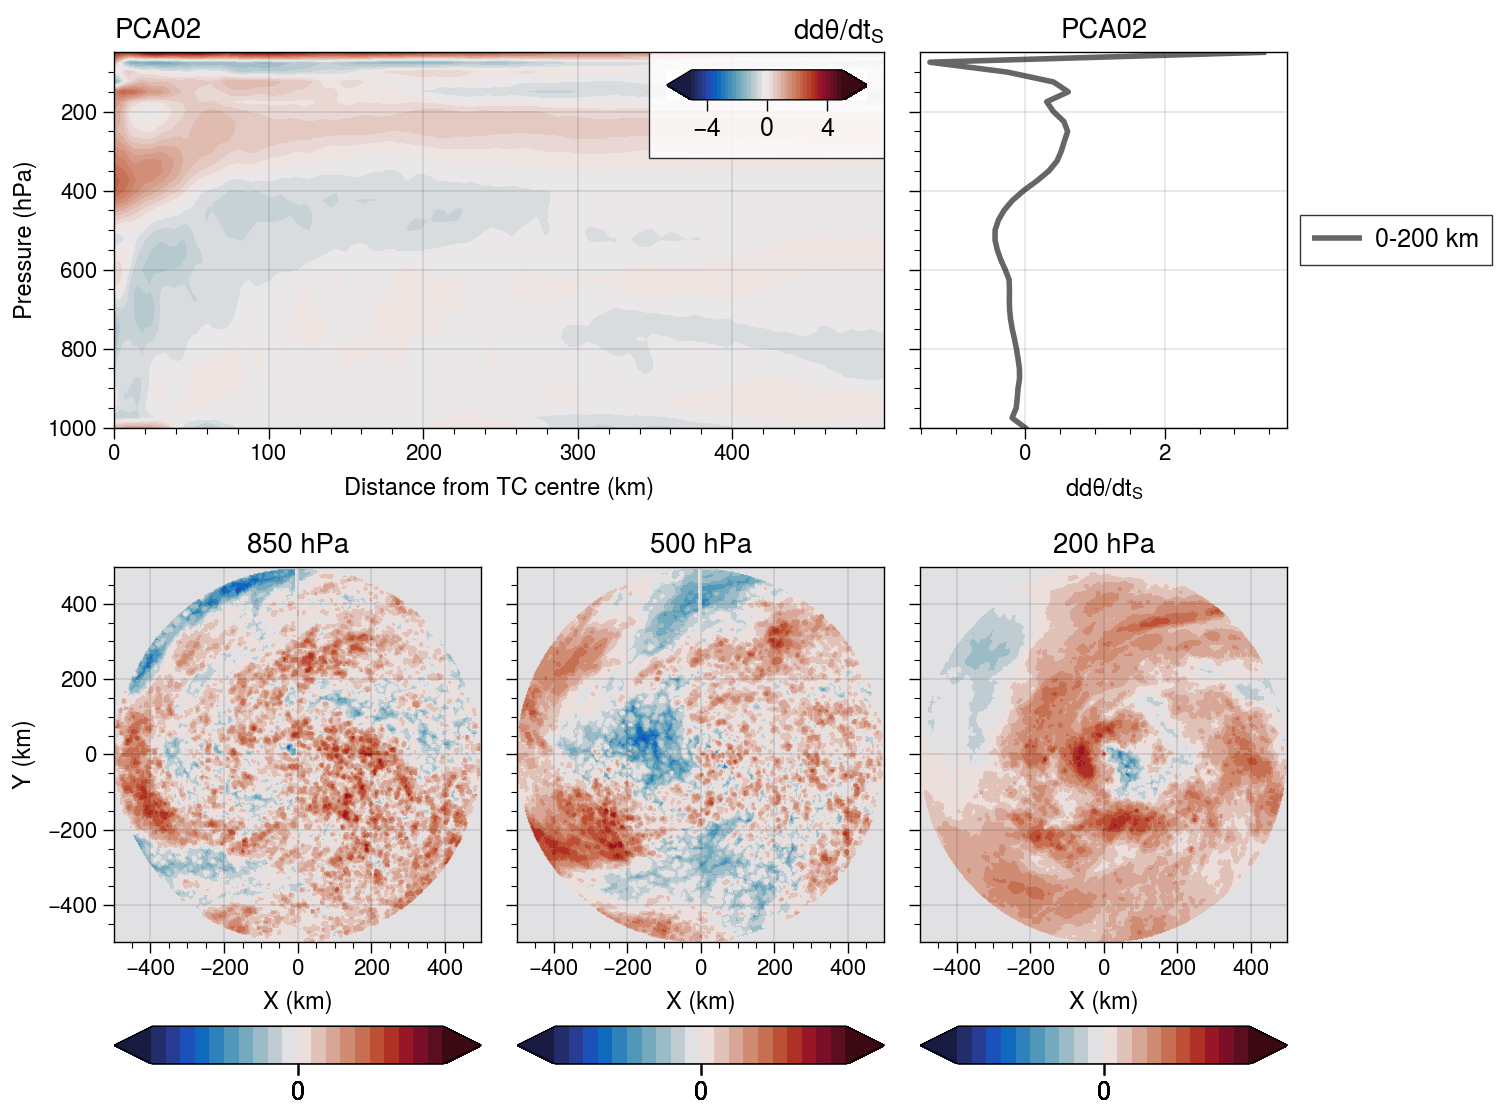

In [20]:
from IPython.display import display, Image
display(Image('./proc_fig/1212/pca_dtheta/structure_dthdt_PCA02.png'))

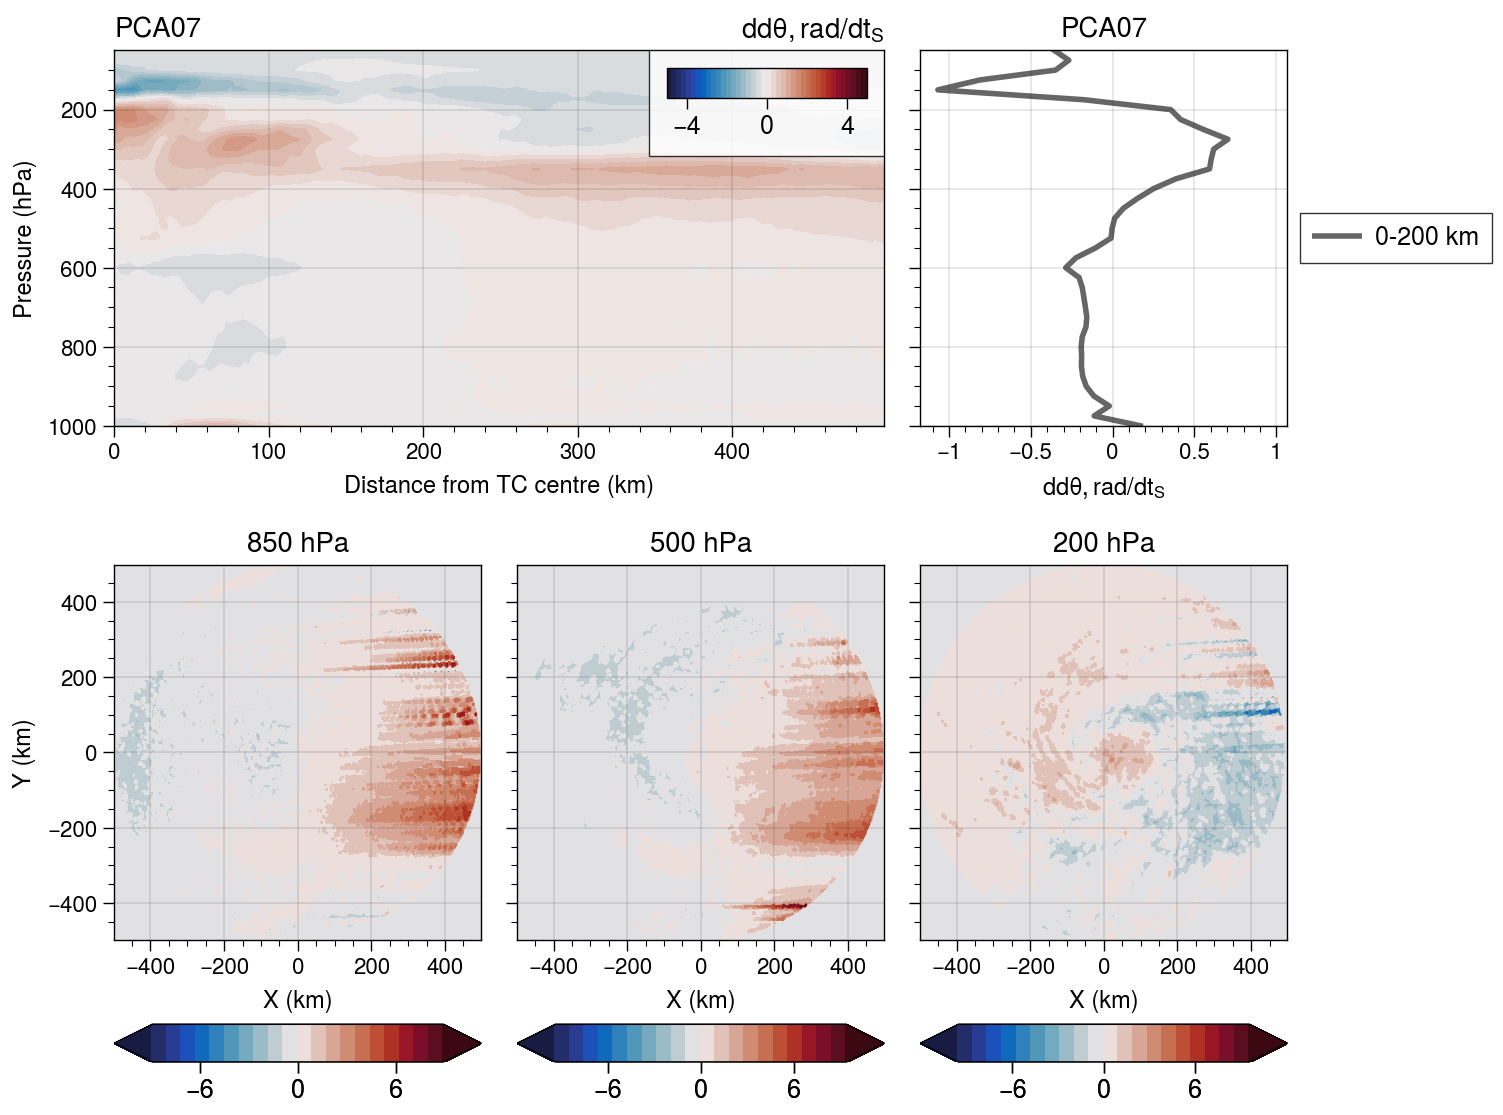

In [38]:
############################################################################################################################################
array = [[1, 1, 2],[3, 4, 5]]
plotcomp=6
plotarray = rad_corrmap
plotlabel = r'd$d\theta,rad/$dt$_{S}$'
fig,axs = plot.subplots(array,axwidth=3.85,refaspect=2.051,span=False,sharex=False)
display_crosssection(plotarray,ctrlvar_dict['U10'].radius[:r500],coor.pres,plotcomp,
                     True,axs[0],plotlabel,np.linspace(-5,5,41),[-4,0,4])
display_avgprofil(plotarray,coor.pres,plotcomp,True,[0,r200,r500],axs[1],plotlabel,['k','r'],2,0.6)
display_cart(plotarray,[axs[2],axs[3],axs[4]],plotcomp,[6,20,32],NEWCART_axis,ANGLE)
plt.savefig('./proc_fig/1212/structure_dthraddt_PCA0'+str(plotcomp+1)+'.png',dpi=400)
plt.show()

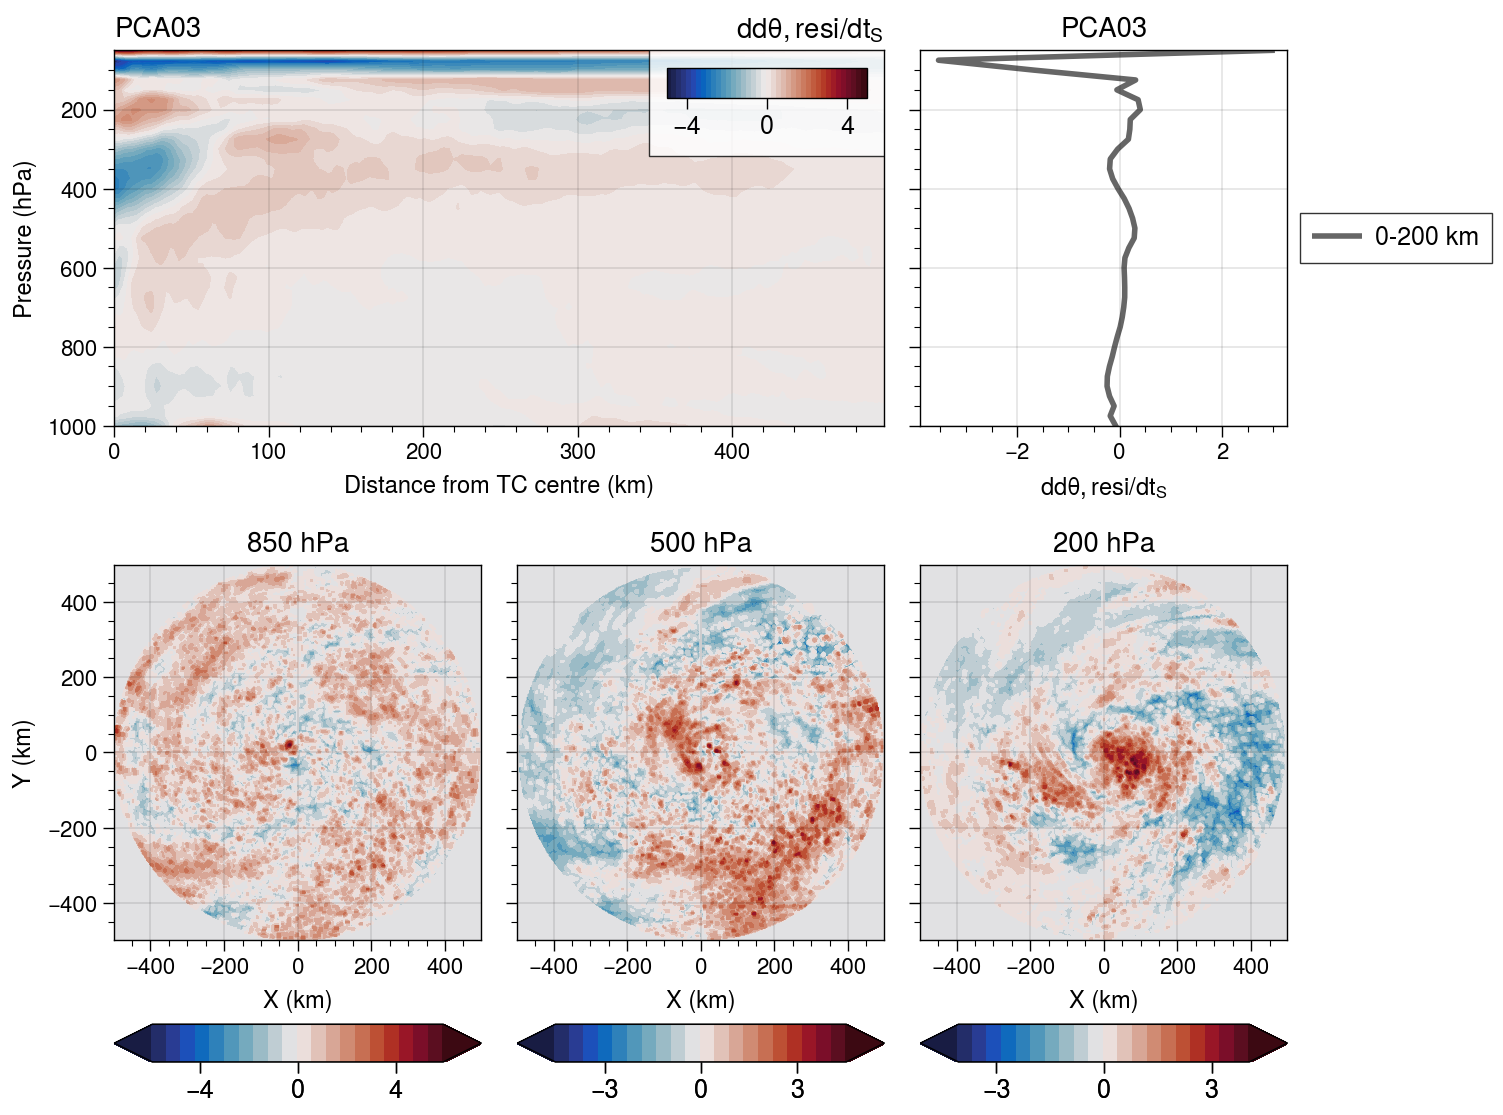

In [44]:
############################################################################################################################################
array = [[1, 1, 2],[3, 4, 5]]
plotcomp=2
plotarray = resi_corrmap
plotlabel = r'd$d\theta,resi/$dt$_{S}$'
fig,axs = plot.subplots(array,axwidth=3.85,refaspect=2.051,span=False,sharex=False)
display_crosssection(plotarray,ctrlvar_dict['U10'].radius[:r500],coor.pres,plotcomp,
                     True,axs[0],plotlabel,np.linspace(-5,5,41),[-4,0,4])
display_avgprofil(plotarray,coor.pres,plotcomp,True,[0,r200,r500],axs[1],plotlabel,['k','r'],2,0.6)
display_cart(plotarray,[axs[2],axs[3],axs[4]],plotcomp,[6,20,32],NEWCART_axis,ANGLE)
plt.savefig('./proc_fig/1212/structure_dthresidt_PCA0'+str(plotcomp+1)+'.png',dpi=400)
plt.show()